# GRU 기반의 삼성전자 주가 예측

## <span style="font-size:25px">Data 가져오기</span>

In [ ]:
import FinanceDataReader as fdr
import pandas as pd

df = fdr.DataReader(f'YAHOO:005930.KS')
#df

In [2]:
df['3MA'] = df['Adj Close'].rolling(window=3).mean()    # 3일 선
df['5MA'] = df['Adj Close'].rolling(window=5).mean()    # 5일 선

df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '3MA', '5MA']]
#df

In [16]:
df.to_csv('./datafile/삼성전자25-02-07.csv')

## <span style="font-size:25px">개발 과정 - 시계열 데이터 분석 및 예측</span>

<dl>
<dt style="font-size:20px">▶ 데이터 로드 및 분포 확인</dt>
<dd style="font-size:18px">
✔ dt=pd.read_csv(), df.describe(), df.hist(), plot() 등
</dd>

<br>
<dt style="font-size:20px">▶ 데이터 전처리</dt>
<dd style="font-size:18px">
✔ outlier / missing value 확인 후 대체(또는 삭제) 처리
<br>
<br>✔ 데이터 정규화(normalization) / 표준화(standardization)
<br>
<br>✔ 딥러닝 학습을 위한 feature column / label column 정의
</dd>

<br>
<dt style="font-size:20px">▶ 데이터 생성</dt>
<dd style="font-size:18px">
✔ window size 설정 후 feature / label 시계열 데이터 생성
<br>
<br>✔ 학습 데이터 생성. 이때 입력 데이터는 (batch_size, time_step, 
<br>　 input_dims) 형태의 3차원 텐서로 생성되어야 함
</dd>

<br>
<dt style="font-size:20px">▶ 순환신경망 모델 구축 및 학습</dt>
</dl>

## <span style="font-size:25px">데이터 로드 및 분포확인</span>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [6]:
raw_df = pd.read_csv('./datafile/삼성전자25-02-07.csv')
raw_df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4375.401855,74195000,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,3995.864502,74680000,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4024.508545,54390000,4131.924967,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,3967.221191,40305000,3995.864746,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4131.926270,46880000,4041.218669,4098.984473


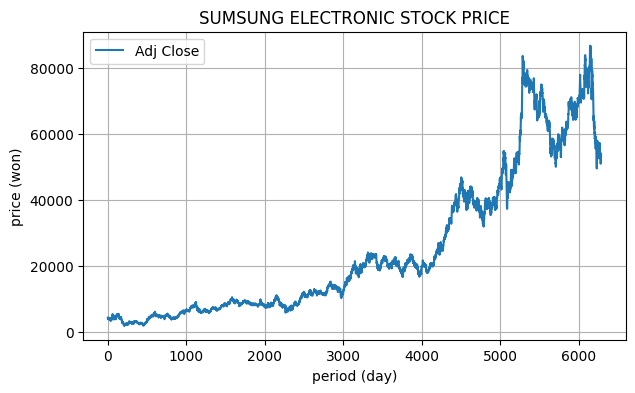

In [7]:
plt.figure(figsize=(7, 4))

plt.title('SUMSUNG ELECTRONIC STOCK PRICE')
plt.xlabel('period (day)')
plt.ylabel('price (won)')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')
plt.legend(loc='best')

plt.show()

## <span style="font-size:25px">데이터 전처리</span>

### <span style="font-size:23px">Outlier 확인</span>

In [8]:
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,6284.000000,6284.00000,6284.000000,6284.000000,6284.000000,6.284000e+03,6282.000000,6280.000000
mean,29302.458625,29589.49077,29005.682686,29290.700191,25117.107455,2.121077e+07,25115.863476,25114.736012
std,23131.602333,23318.49323,22926.957773,23107.096718,22408.355823,1.494993e+07,22404.397379,22401.148536
min,2540.000000,2760.00000,2420.000000,2730.000000,1954.965942,0.000000e+00,1997.932292,2012.254272
25%,10900.000000,11020.00000,10720.000000,10880.000000,7862.832031,1.175840e+07,7886.701782,7873.810913
50%,22580.000000,22840.00000,22400.000000,22620.000000,17676.513672,1.725485e+07,17702.696940,17748.369727
75%,46850.000000,47205.00000,46400.000000,46900.000000,39350.039062,2.628737e+07,39383.919271,39336.425391
max,90300.000000,96800.00000,89500.000000,91000.000000,86718.812500,1.642150e+08,86652.966146,86462.015625


In [9]:
raw_df.isnull().sum()

Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
3MA           2
5MA           4
dtype: int64

In [13]:
raw_df.loc[raw_df['5MA'].isna()]

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4375.401855,74195000,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,3995.864502,74680000,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4024.508545,54390000,4131.924967,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,3967.221191,40305000,3995.864746,NaN


### <span style="font-size:23px">Outlier 및 Missing Value 처리</span>

In [14]:
# 0 제거 전

for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Unnamed: 0: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 127
3MA: 0
5MA: 0


In [16]:
# Volume 값이 0인 부분을 모두 NAN으로 대체(replace)
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 Column에 0 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Unnamed: 0: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [17]:
# 모든 Missing Value 삭제
raw_df.isnull().sum()

Unnamed: 0      0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume        127
3MA             2
5MA             4
dtype: int64

In [18]:
raw_df = raw_df.dropna()
raw_df.isnull().sum()

Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
3MA           0
5MA           0
dtype: int64

### <span style="font-size:23px">정규화(Normalizaion)</span>

In [21]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 
              '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])
print(type(scaled_df))

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

<class 'numpy.ndarray'>
          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.025683  0.024137  0.024544   
1     0.037375  0.035517  0.038470  0.034440   0.025683  0.024560  0.023968   
2     0.034982  0.031689  0.036518  0.033873   0.025260  0.025067  0.024205   
3     0.034868  0.031689  0.036059  0.033760   0.025176  0.024898  0.024358   
4     0.036235  0.033177  0.037437  0.035120   0.026190  0.025067  0.024850   
...        ...       ...       ...       ...        ...       ...       ...   
6148  0.553327  0.517227  0.555581  0.546845   0.578608  0.594988  0.603934   
6149  0.559025  0.540621  0.563620  0.566104   0.598664  0.591051  0.600144   
6150  0.581814  0.542748  0.578548  0.568370   0.601023  0.593019  0.598249   
6151  0.579535  0.544875  0.583142  0.580832   0.614000  0.604832  0.598960   
6152  0.585232  0.547001  0.587735  0.577433   0.610461  0.608769  0.602039   

        Volume  
0     0.28

### <span style="font-size:23px">feature / label column 정의</span>

In [23]:
feature_cols = ['3MA', '5MA', 'Adj Close']
label_cols = ['Adj Close']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

## <span style="font-size:23px">데이터 생성 - 입력 데이터(feature) / 정답 데이터(label)</span>

In [27]:
def seq2dataSet(feat, lab, window_size):
    feat_list, lab_list = [], []
    for i in range(len(feat)-window_size):
        feat_list.append(feat[i:i+window_size])
        lab_list.append(lab[i+window_size])
    return np.array(feat_list), np.array(lab_list)

In [28]:
X, Y = seq2dataSet(feature_np, label_np, window_size=40)
print(X.shape, Y.shape)

(6113, 40, 3) (6113, 1)


## <span style="font-size:23px">데이터 분리 및 모델구축</span>

In [29]:
# 트레이닝 / 테스트 데이터 분리
split_ratio = 0.9
split = int(X.shape[0] * split_ratio)
x_train = X[:split]
t_train = Y[:split]
x_test = X[split:]
t_test = Y[split:]

print(x_train.shape, t_train.shape, 
      x_test.shape, t_test.shape)

(5501, 40, 3) (5501, 1) (612, 40, 3) (612, 1)


In [34]:
rnn = Sequential([
    GRU(256, activation='tanh', input_shape=x_train[0].shape, 
        return_sequences=True),
    GRU(256, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 40, 256)           200448    
                                                                 
 gru_6 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 595,457
Trainable params: 595,457
Non-trainable params: 0
_________________________________________________________________


In [35]:
from tensorflow.keras.callbacks import EarlyStopping
rnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
rnn.fit(x_train, t_train, batch_size=16, epochs=100, 
        validation_data=(x_test, t_test), callbacks=[early_stop])

Epoch 1/100
344/344 [==============================] - 6s 12ms/step - loss: 9.4614e-04 - mae: 0.0154 - val_loss: 0.0012 - val_mae: 0.0292
Epoch 2/100
344/344 [==============================] - 4s 10ms/step - loss: 4.4494e-04 - mae: 0.0137 - val_loss: 2.6240e-04 - val_mae: 0.0120
Epoch 3/100
344/344 [==============================] - 3s 10ms/step - loss: 3.7665e-04 - mae: 0.0128 - val_loss: 2.1793e-04 - val_mae: 0.0109
Epoch 4/100
344/344 [==============================] - 3s 10ms/step - loss: 3.3512e-04 - mae: 0.0116 - val_loss: 3.8287e-04 - val_mae: 0.0161
Epoch 5/100
344/344 [==============================] - 4s 11ms/step - loss: 2.8455e-04 - mae: 0.0109 - val_loss: 2.9967e-04 - val_mae: 0.0139
Epoch 6/100
344/344 [==============================] - 4s 10ms/step - loss: 2.3878e-04 - mae: 0.0100 - val_loss: 2.0473e-04 - val_mae: 0.0108
Epoch 7/100
344/344 [==============================] - 4s 10ms/step - loss: 2.3889e-04 - mae: 0.0097 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 8/100
34

20/20 [==============================] - 1s 17ms/step


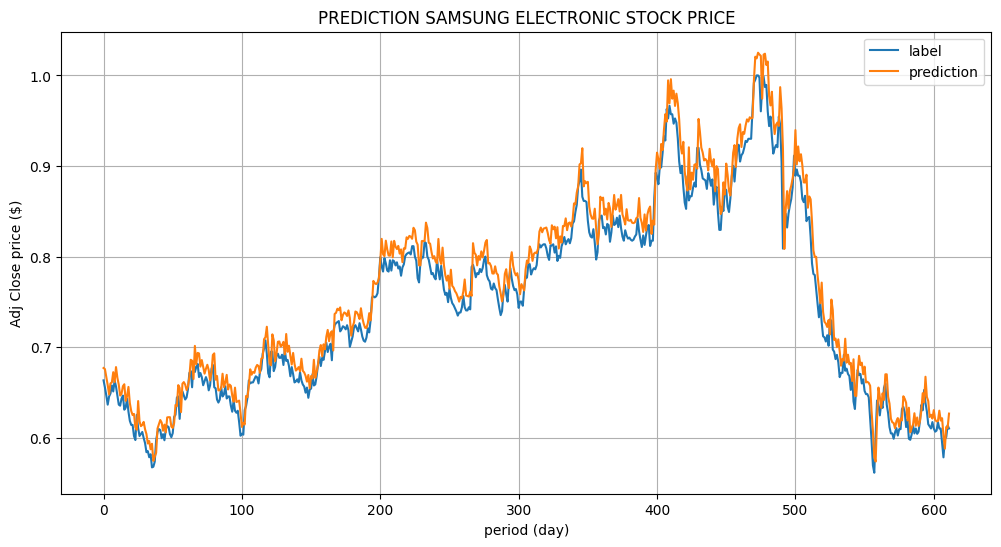

In [36]:
pred = rnn.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('PREDICTION SAMSUNG ELECTRONIC STOCK PRICE')
plt.xlabel('period (day)')
plt.ylabel('Adj Close price ($)')
plt.grid()

plt.plot(t_test, label='label')
plt.plot(pred, label='prediction')
plt.legend(loc='best')